# Grad-CAM은 마지막 conv 레이어에 들어오는 gradient 정보를 사용해서 타겟 레이블에 대해 각 뉴런이 가지는 중요도를 이해한다고 한다.

### Class Activation Map(CAM) : 오브젝트 디텍션 용도로 만들어진 신경망을 들여다 볼 수 있음

### *model.summary() 메소드를 통해 model에 대한 구조를 보게되면 맨 마지막 convlution layer만이 아니라 모든 활성레이어 계층 확인이 가능

#### CAM은 오브젝트 디텍션 용도로 만들어진 신경망을 들여다 볼 수 있음
#### 이를 더 일반화하여 볼 수 있도록 한것이 Grad_CAM이다.

#### 마지막 conv 레이어에 들어오는 gradient 정보를 사용해서 타겟 레이블에 대해 각 뉴런이 가지는 중요도를 이해한다고 한다.


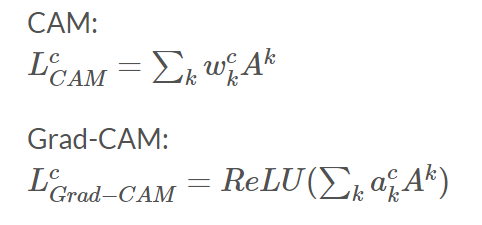

## CAM : Grad-CAM 두가지의 차이점은 RELU 함수의 차이


참고<br>
https://jsideas.net/grad_cam/<br>
https://keras.io/examples/vision/grad_cam/#the-gradcam-algorithm

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.models import load_model
from keras.preprocessing import image
model = load_model('categorymodel.h5')


model.summary()

1 Physical GPUs, 1 Logical GPUs
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________

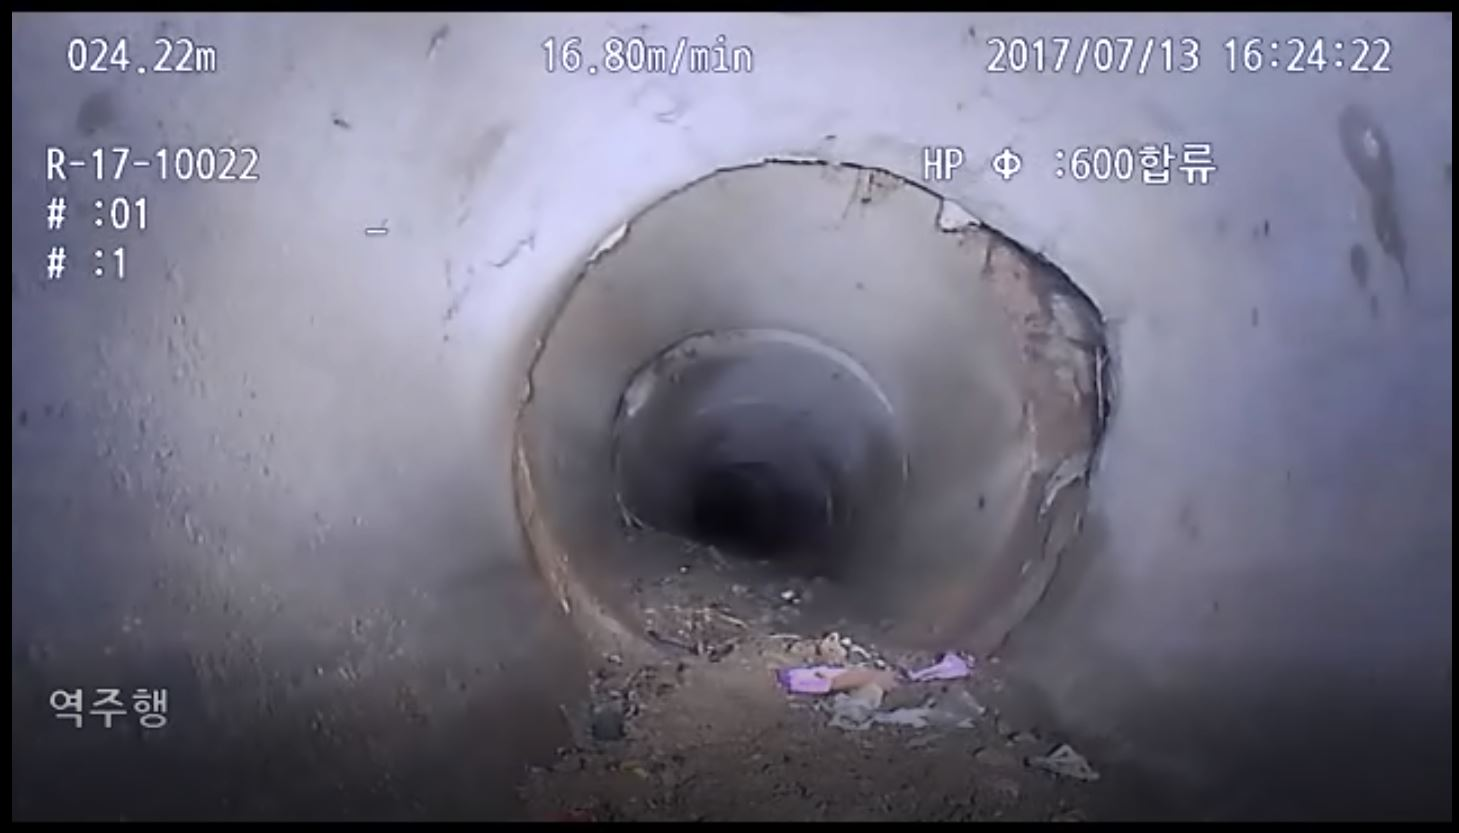

In [8]:
#model_builder = keras.applications.xception.Xception
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
#decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "relu"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]

# The local path to our target image
#img_path = keras.utils.get_file(
#     "african_elephant.jpg", " https://i.imgur.com/Bvro0YD.png"
#)

img_path='캡처2.jpg'



display(Image(img_path))


In [9]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)/255
    #
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    print(array)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
       
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    print(heatmap)
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

[[[[0.         0.         0.01568628]
   [0.         0.         0.        ]
   [0.         0.         0.01568628]
   ...
   [0.00392157 0.         0.02352941]
   [0.00392157 0.00392157 0.00392157]
   [0.         0.         0.00784314]]

  [[0.         0.         0.00784314]
   [0.         0.         0.        ]
   [0.00392157 0.         0.02352941]
   ...
   [0.00392157 0.00784314 0.        ]
   [0.00392157 0.00392157 0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.03529412]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.01960784]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.01176471 0.01176471 0.01176471]
   [0.         0.         0.00784314]
   ...
   [0.         0.         0.00784314]
   [0.         0.         0.00784314]
   [0.         0.         0.00784314]]

  [[0.         0.         0.        ]
   [0. 

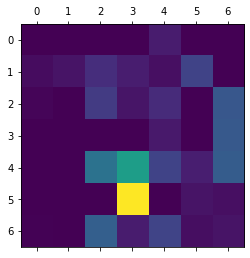

In [10]:

#xeption 은 각 셀의 값을 -1 ~ 1 사이의 값으로 초기화
#img_array = preprocess_input(get_img_array(img_path, size=img_size))

#구현해둔 DenseNet 모델은 0~1사이의 값으로 초기화
#get_img_array 메소드 4번줄 각셀의 값에 255를 나누어줌
img_array = get_img_array(img_path, size=img_size)
print('===============================================')
print(img_array)
# Make model
# model =model_builder(weights="imagenet")
# Print what the top predicted class is
preds = model.predict(img_array)
print(np.argmax(preds))
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

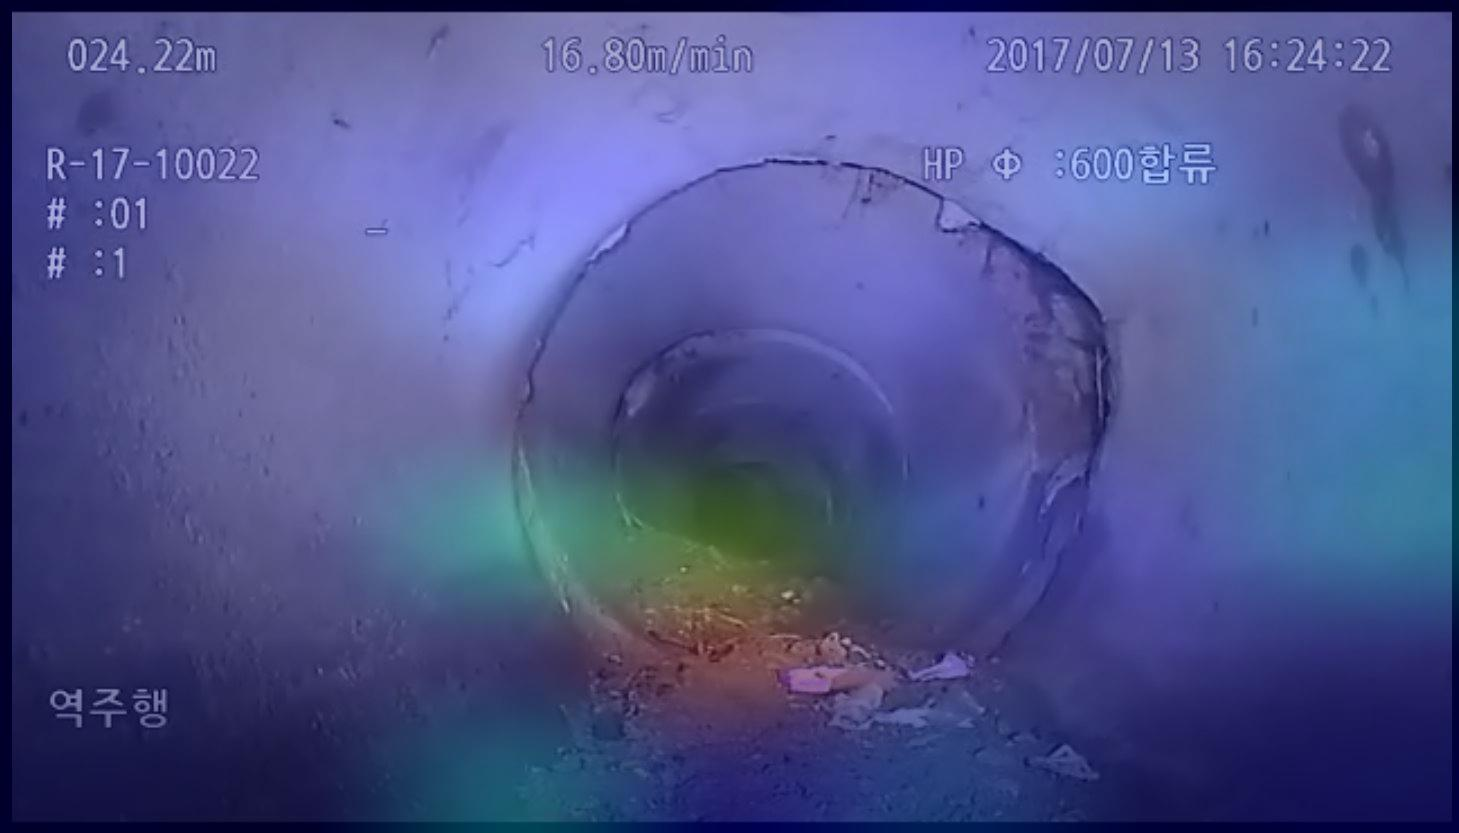

In [11]:
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.5 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "output.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))